# Semantic Segmentation of Colon Cancer Primaries

This is a demonstration of our deep learning pipeline to predict segmentation masks of colon cancer primaries in CT images.

We built our program so that it can easily be run from the command line. In this demonstration we will nevertheless import our functions and create and created an `Args()` class that can be used to specify the settings usually passed by the command line prompt. How to run our program from the command line is shown in the README.md file.

## Convert NIfTI to Numpy

To train our model and to predict segmentation masks we use axial 2D slices of the CT images, however the original data is provided in 3D NifTI files. We defined the `convert_to_npy()` function to convert 3D NifTI image files to 2D numpy files and save them. In this function we additionally create a JSON file that indexes every single slice. In this index we provide information of whether each slice containes tissue labled as cancer.

In the JSON file we assign each slice to the training or test subsets by calling `create_data_subsets()`. Here, the split ratio and whether to create a split based on individual slices or examples (patients) should be created. For our models we split on individual slices and ensured that the ratio between cancer and non-cancer slices is equal in test and training subset.

Both functions (`convert_to_npy()` and `create_data_subsets()`) are in `dataset.py`.


In [ ]:
from dataset import convert_to_npy, create_data_subsets

In [ ]:
class Args():
    data_path = './Task10_Colon'
    path = './data/'
    split_on = "slices"
    split = 0.1

args = Args()

convert_to_npy(args)
create_data_subsets(args)

## Dataset and Data Loader

### Dataset

We created a custom dataset class *ColonDataset*. It uses JSON file created by the `create_data_subsets()` function to load the image files assigned to the test or training subsets. The `ColonDataset()` class is defined in `data_loading.py`.  

When instantiating the `ColonDataset()` class a sampling method can be set. Otherwise, it returns the original dataset.

The three custom sampling methods are *undersample*, *oversample* and *only_tumor*. The sampling methods are defined as `get_undersample_files()`, `get_oversample_files()`, `get_only_tumor_files()`, and `get_original_dataset()` in `data_loading.py`. 

If the dataset is used for training, the images are augmented by several transformations: resize, random crop, horizontal flipping, vertical flipping, and normalization. Data used in model testing is only resized and normalized.

After instantiating `ColonDataset()` the dataset is split into training and validation set. This logic is implemented in the `load_datasets()` function. The `load_datasets()` function is in `train.py`.

### Data Loader

We use the `DataLoader` function from **pytorch** (torch.utils.data.DataLoader). In the `load_dataloader()` function, two dataloaders (training and validation set) are created and saved in a dictionary as 'train' and 'val'. This dictionary is used in the training loop later.

In [ ]:
from train import load_datasets, load_dataloader
from utils import get_subset_stats

In [ ]:
class Args():
    split_ratio = 0.9
    train_batch = 12
    valid_batch = 12
    trainimages = "./data/npy_images"
    trainlabels = "./data/npy_labels"
    jsonfile = "./data/data_index_subsets.json"
    transform = True
    dataset_type = "only_tumor"
    image_size = 256

args = Args()

In [ ]:
train, valid = load_datasets(args)
train_dataloader = load_dataloader(args, train, valid)

In [ ]:
get_subset_stats(args.jsonfile)

## Visualizing Images

Here we plot several CT images from the first batch of train_dataloader. These images are automatically transformed by the transformations described above.

In [ ]:
import matplotlib.pyplot as plt
from utils import gray2rgb, outline

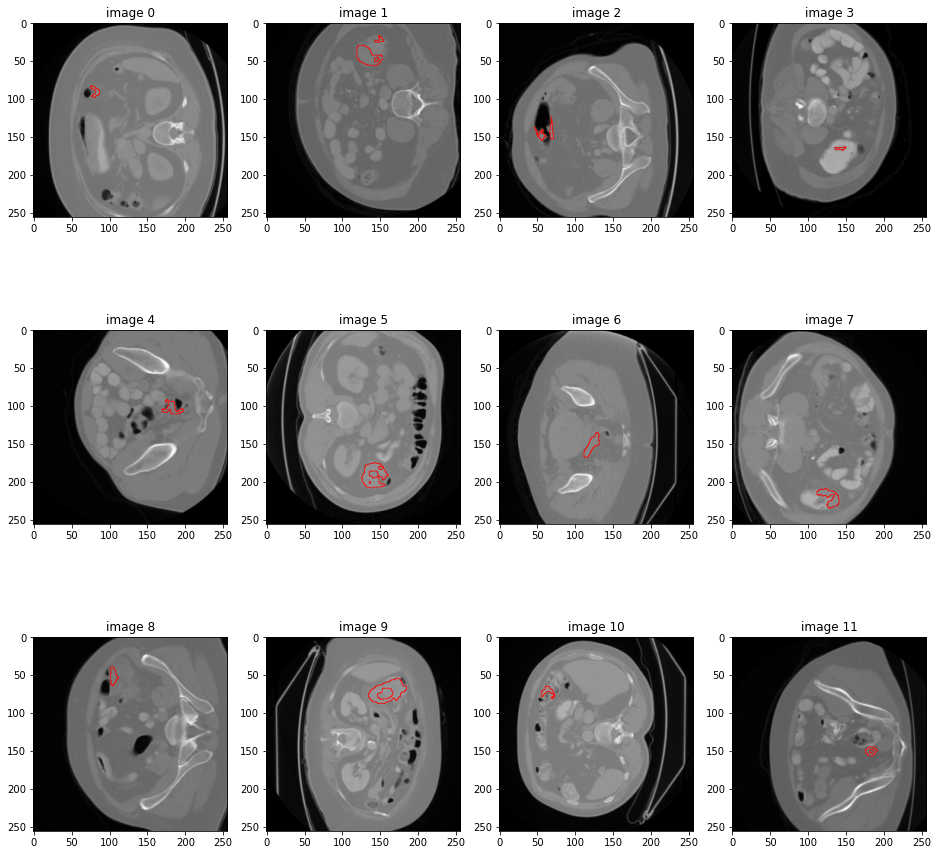

In [ ]:
imgs, labels = next(iter(train_dataloader['train']))

def overlay_plot(img, y_true):
    image = gray2rgb(img[0])
    image = outline(image, y_true[0], color=[255, 0, 0])
    plt.imshow(image)

columns = 4
rows = 3
fig=plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(imgs, labels)):
    fig.add_subplot(rows, columns, i+1)
    plt.title('image ' + str(i))
    overlay_plot(img, label)

## Model Architecture

In our project we compare two model architectures: the U-Net model and the combination of a ResNet-34 with the U-Net for the image segmentation task. In this demo, we show the U-Net model only. Both models are implemented in `architecture.py`.

In [ ]:
from architecture import UNet

In [ ]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
model = UNet(n_channel=1, n_class=1).to(device)
summary(model, input_size=(1, args.image_size, args.image_size))

RuntimeError: CUDA error: out of memory

## Loss Function

To optimize our models in training we combine the cross entropy loss with the dice loss. 

The cross entropy loss is from *pytorch library*. We implemented the dice coefficient in `loss.py`. The dice loss is calculated as *(1 - dice coefficient)*.

In [ ]:
from loss import dice_coef, calc_loss, print_metrics

## Training

We use the *SGD (Stochastic gradient descent)* optimizer in training. As learning rate scheduler we used *ReduceLROnPlateau*. It allows to dynamically reduce the learning rate based on the validation loss. Both of them are from the **pytorch** library. 

We further implemented an early wtopping technique is also implemented in `train.py`. Early stopping is a method that allows you to specify a maximum number of training epochs after which the training is stopped if the validation loss did not improve.

We define the `train_model()` function in `train.py`. This function takes the optimizer, scheduler, and other parameters as arguments and starts training. It saves the model which shows the lowest validation loss. 

We use Tensorboard to visualize the metrics after finishing training. We also save the metrics as a JSON file to allow us compare the results of each model easily.


In [ ]:
from train import train_model

In [ ]:
class Args():
    model_path = "./save/models/"
    metric_path = "./save/metrics"
    model = "unet"
    dataset_type = "only_tumor"
    lr = 0.001
    epochs = 200
    earlystop = 30
    sched_patience = 10
    
args = Args()

In [ ]:
# set device
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
# specify optimizer function
optimizer = SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, momentum=0.9)
# initialise learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold_mode='abs', min_lr=1e-8, factor=0.1, patience=args.sched_patience)
# intialize the model
model = UNet(n_channel=1, n_class=1).to(device)
# initialize dictionary to save train informations about the model, dataset, and metrics at the end.
info = {'train': {}}
info_train = info['train']
info_train['model'] = args.model
info_train['dataset'] = args.dataset_type
info_train['image_size'] = args.image_size
info_train['train set size'] = len(train)
info_train['val set size'] = len(valid)
# start train
model, metric_t, metric_v = train_model(model, optimizer, scheduler, device, args.epochs, colon_dataloader, info_train)

with open(f"{args.metric_path}best_metric_{args.model}_{args.dataset_type}_{args.epochs}.json", "w") as json_file:
    json.dump(info, json_file, indent=4)

In [ ]:
# to see visualizations of loss change
!tensorboard --logdir=runs

## Testing

We define `load_datasets()` and `load_dataloader()` functions in `test.py` to load the test set which was split into test and training set before. The information which image belongs to which subset is drawn from the JSON data index. 

Similar to `train_model()` in training we defined `test_model()` in `test.py` which starts evaluating the model and prints the evaluation metrics at the end. The evaluation metrics are saved in the metrics JSON file. We created a `metrics_summary()` function in `utils.py`, which returns statistics on each model approach.

In our experiments the U-Net model based on an *oversampled* dataset yielded the best performance metrics. In this demo, we are going to load this model to demonstrate its predictions.

In [ ]:
from test import load_datasets, load_dataloader, test_model
from utils import metrics_summary

In [ ]:
class Args():
    testimages = "./data/npy_images"
    testlabels = "./data/npy_labels"
    jsonfile = "./data/data_index_subsets.json"
    image_size = 256
    transform = True
    model_path = "./save/models/"
    metric_path = "./save/metrics"
    model = "unet"
    datset_type = "oversample"
    epochs = 200
    pred_save = True
    
args = Args()

In [ ]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
model = UNet(n_channel=1, n_class=1).to(device)
test = load_datasets(args)
test_dataloader = load_dataloader(test)
# initialize a dictionary to save metrics for evaluation
info_test = {'test set size':0, 'average_dice_score':0, \
             'number of cancer case': 0, 'average_cancer_dice_score':0, \
             'number of non-cancer case': 0, 'average_non_cancer_dice_score':0, \
             'gt_c_pd_c_overlap':0, 'gt_c_pd_c_no_overlap':0, 'gt_c_pd_no_c':0, \
             'gt_n_pd_n': 0, 'gt_n_pd_c':0, 'dice_score_each_slice':[]}
info_test['test set size'] = len(colon_dataloader['test'])
# start test
result = test_model(model, device, colon_dataloader, args.pred_save, info_test)
# print out statistics
metrics_summary(args.metrics_path)

## Visualize predictions from the trained model
It's not tested yet


In [ ]:
import matplotlib.pyplot as plt
from utils import gray2rgb, outline, overlay_plot

In [ ]:
random_index = np.random.choice(len(result), 10)
fig=plt.figure(figsize=(16, 16))
for i in random_index:
    overlay_plot(result[i]['img'], result[i]['label'], result[i]['pred'], i, False):